In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
import time
import pandas as pd
import seaborn as sn
import keras
import os
import cv2
import pickle
import random
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid
from keras.preprocessing.image import ImageDataGenerator
# import matplotlib
# matplotlib.use("Agg")

Using TensorFlow backend.


In [2]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 500
INIT_LR = 1e-2
BS = 32
IMAGE_DIMS = (224, 224, 3)

In [3]:
from imutils import paths

imagePaths = sorted(list(paths.list_images("anger_classification")))
random.seed(42)
random.shuffle(imagePaths)
imagePaths

['anger_classification\\non_anger\\non_anger_143.jpg',
 'anger_classification\\non_anger\\non_anger_888.jpg',
 'anger_classification\\non_anger\\non_anger_737.jpg',
 'anger_classification\\non_anger\\non_anger_161.jpg',
 'anger_classification\\non_anger\\non_anger_2171.jpg',
 'anger_classification\\non_anger\\non_anger_1294.jpg',
 'anger_classification\\non_anger\\non_anger_1630.jpg',
 'anger_classification\\non_anger\\non_anger_427.jpg',
 'anger_classification\\non_anger\\non_anger_1039.jpg',
 'anger_classification\\non_anger\\non_anger_1054.jpg',
 'anger_classification\\non_anger\\non_anger_1827.jpg',
 'anger_classification\\non_anger\\non_anger_1946.jpg',
 'anger_classification\\non_anger\\non_anger_551.jpg',
 'anger_classification\\anger\\anger_444.jpg',
 'anger_classification\\non_anger\\non_anger_558.jpg',
 'anger_classification\\anger\\anger_459.jpg',
 'anger_classification\\non_anger\\non_anger_111.jpg',
 'anger_classification\\non_anger\\non_anger_632.jpg',
 'anger_classificat

In [4]:
from keras.preprocessing.image import img_to_array

data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [5]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 3542.11MB


In [6]:
from sklearn.preprocessing import LabelBinarizer

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [7]:
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

In [8]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [9]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [10]:
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] done compiling.")

[INFO] compiling model...
[INFO] done compiling.


In [11]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [12]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1, class_weight={0:3, 1:1})

# save the model to disk
print("[INFO] serializing network...")
model.save("anger_{3,1}_SmallVGG_200_epochs.model")

[INFO] training network...
Epoch 1/500
75/75 [==============================] - 23s 313ms/step - loss: 2.7328 - accuracy: 0.5006 - val_loss: 60.0018 - val_accuracy: 0.7065
Epoch 2/500
75/75 [==============================] - 19s 250ms/step - loss: 2.0678 - accuracy: 0.4880 - val_loss: 22.0050 - val_accuracy: 0.6899
Epoch 3/500
75/75 [==============================] - 19s 251ms/step - loss: 2.3230 - accuracy: 0.5065 - val_loss: 28.1244 - val_accuracy: 0.2720
Epoch 4/500
75/75 [==============================] - 18s 246ms/step - loss: 2.2511 - accuracy: 0.5128 - val_loss: 3.6655 - val_accuracy: 0.6219
Epoch 5/500
75/75 [==============================] - 18s 244ms/step - loss: 1.9862 - accuracy: 0.5124 - val_loss: 0.8672 - val_accuracy: 0.5655
Epoch 6/500
75/75 [==============================] - 18s 244ms/step - loss: 1.8355 - accuracy: 0.4977 - val_loss: 1.2235 - val_accuracy: 0.2819
Epoch 7/500
75/75 [==============================] - 18s 241ms/step - loss: 1.5441 - accuracy: 0.4989 - va

75/75 [==============================] - 20s 267ms/step - loss: 0.9345 - accuracy: 0.6672 - val_loss: 0.5601 - val_accuracy: 0.7214
Epoch 114/500
75/75 [==============================] - 20s 270ms/step - loss: 0.9160 - accuracy: 0.6571 - val_loss: 0.6265 - val_accuracy: 0.6501
Epoch 115/500
75/75 [==============================] - 20s 263ms/step - loss: 0.9210 - accuracy: 0.6708 - val_loss: 0.9565 - val_accuracy: 0.3085
Epoch 116/500
75/75 [==============================] - 20s 269ms/step - loss: 0.9179 - accuracy: 0.6704 - val_loss: 0.7996 - val_accuracy: 0.4113
Epoch 117/500
75/75 [==============================] - 20s 269ms/step - loss: 0.8737 - accuracy: 0.6655 - val_loss: 0.7963 - val_accuracy: 0.6053
Epoch 118/500
75/75 [==============================] - 20s 262ms/step - loss: 0.9164 - accuracy: 0.6706 - val_loss: 0.5703 - val_accuracy: 0.7164
Epoch 119/500
75/75 [==============================] - 20s 267ms/step - loss: 0.9160 - accuracy: 0.6773 - val_loss: 0.5663 - val_accuracy:

75/75 [==============================] - 18s 241ms/step - loss: 0.7639 - accuracy: 0.7480 - val_loss: 1.1323 - val_accuracy: 0.4411
Epoch 226/500
75/75 [==============================] - 18s 242ms/step - loss: 0.7584 - accuracy: 0.7425 - val_loss: 0.7849 - val_accuracy: 0.6119
Epoch 227/500
75/75 [==============================] - 18s 242ms/step - loss: 0.7861 - accuracy: 0.7451 - val_loss: 0.6499 - val_accuracy: 0.7181
Epoch 228/500
75/75 [==============================] - 18s 241ms/step - loss: 0.7629 - accuracy: 0.7480 - val_loss: 0.6764 - val_accuracy: 0.6882
Epoch 229/500
75/75 [==============================] - 18s 241ms/step - loss: 0.7238 - accuracy: 0.7505 - val_loss: 0.7843 - val_accuracy: 0.5920
Epoch 230/500
75/75 [==============================] - 19s 251ms/step - loss: 0.7098 - accuracy: 0.7682 - val_loss: 0.9912 - val_accuracy: 0.4975
Epoch 231/500
75/75 [==============================] - 19s 250ms/step - loss: 0.7056 - accuracy: 0.7535 - val_loss: 0.6789 - val_accuracy:

75/75 [==============================] - 18s 243ms/step - loss: 0.5359 - accuracy: 0.8422 - val_loss: 0.6278 - val_accuracy: 0.6982
Epoch 338/500
75/75 [==============================] - 18s 243ms/step - loss: 0.5281 - accuracy: 0.8325 - val_loss: 0.8993 - val_accuracy: 0.7330
Epoch 339/500
75/75 [==============================] - 18s 243ms/step - loss: 0.5590 - accuracy: 0.8352 - val_loss: 0.9790 - val_accuracy: 0.5489
Epoch 340/500
75/75 [==============================] - 19s 249ms/step - loss: 0.5269 - accuracy: 0.8389 - val_loss: 1.3112 - val_accuracy: 0.5091
Epoch 341/500
75/75 [==============================] - 19s 252ms/step - loss: 0.5907 - accuracy: 0.8146 - val_loss: 1.0241 - val_accuracy: 0.6750
Epoch 342/500
75/75 [==============================] - 18s 243ms/step - loss: 0.6370 - accuracy: 0.8187 - val_loss: 0.9196 - val_accuracy: 0.6335
Epoch 343/500
75/75 [==============================] - 18s 244ms/step - loss: 0.5341 - accuracy: 0.8414 - val_loss: 0.9894 - val_accuracy:

75/75 [==============================] - 18s 244ms/step - loss: 0.5009 - accuracy: 0.8500 - val_loss: 0.9174 - val_accuracy: 0.5141
Epoch 450/500
75/75 [==============================] - 18s 241ms/step - loss: 0.5212 - accuracy: 0.8342 - val_loss: 0.7677 - val_accuracy: 0.6982
Epoch 451/500
75/75 [==============================] - 18s 242ms/step - loss: 0.6769 - accuracy: 0.7972 - val_loss: 0.9906 - val_accuracy: 0.6036
Epoch 452/500
75/75 [==============================] - 18s 242ms/step - loss: 0.5254 - accuracy: 0.8422 - val_loss: 0.6452 - val_accuracy: 0.7396
Epoch 453/500
75/75 [==============================] - 18s 239ms/step - loss: 0.6668 - accuracy: 0.7927 - val_loss: 0.6778 - val_accuracy: 0.7380
Epoch 454/500
75/75 [==============================] - 18s 243ms/step - loss: 0.5716 - accuracy: 0.8250 - val_loss: 0.7367 - val_accuracy: 0.7181
Epoch 455/500
75/75 [==============================] - 18s 242ms/step - loss: 0.4958 - accuracy: 0.8633 - val_loss: 0.8128 - val_accuracy:

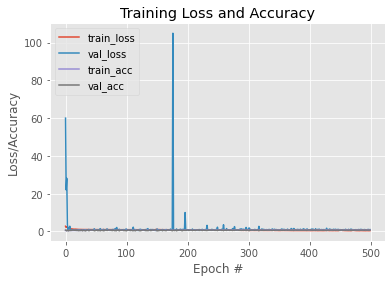

<Figure size 432x288 with 0 Axes>

In [13]:
plt.style.use("ggplot")
%matplotlib inline
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('anger_{3,1}_SmallVGG_200_epochs.png', dpi=100)

In [14]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
 

# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)

Classification report: 
---------------------------------------------------------- 
              precision    recall  f1-score   support

       anger       0.45      0.54      0.49       164
   non-anger       0.81      0.75      0.78       439

    accuracy                           0.69       603
   macro avg       0.63      0.65      0.64       603
weighted avg       0.72      0.69      0.70       603

---------------------------------------------------------- 
Accuracy score: 0.694859
Precision score: 0.814815
Recall score: 0.751708
F1 score: 0.781991
---------------------------------------------------------- 
Confusion matrix: 
[[ 89  75]
 [109 330]]


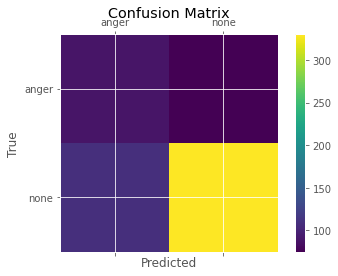

[[ 89  75]
 [109 330]]


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

classif_report = classification_report(testY, yhat_classes, target_names=['anger', 'non-anger'])
print('Classification report: ')
print('---------------------------------------------------------- ')
print(classif_report)

print('---------------------------------------------------------- ')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy score: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision score: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall score: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)
print('---------------------------------------------------------- ')

# confusion matrix
labels = ['anger', 'none']
matrix = confusion_matrix(testY, yhat_classes)
print('Confusion matrix: ')
print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_anger_{3,1}_SmallVGG_200_epochs.png')
plt.show()
print(matrix)